In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from pathlib import Path

import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [22]:
matplotlib.rcParams['figure.figsize'] = (12,12)

In [23]:
# configuration
bs2bk_ratio = 0.5

In [24]:
#function area
!pip install imutils

In [25]:
base_path = Path('../data/')
base_impath = str(base_path.joinpath('idcard/base2.png'))
back_impath = str(base_path.joinpath('background/img1.jpg'))

In [49]:
from datagen.imgen.transforms import transforms
from datagen.imgen.transforms import functional as F
import imutils


base_image = cv.imread(base_impath, cv.IMREAD_UNCHANGED)
back_image = cv.imread(back_impath, cv.IMREAD_COLOR)

# base_image = cv.cvtColor(base_image, cv.COLOR_BGR2RGB)
# back_image = cv.cvtColor(back_image, cv.COLOR_BGR2RGB)

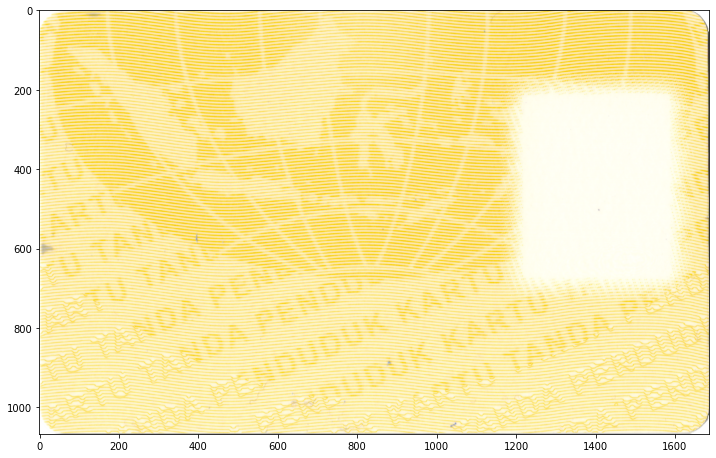

In [50]:
plt.imshow(base_image, cmap='gray')

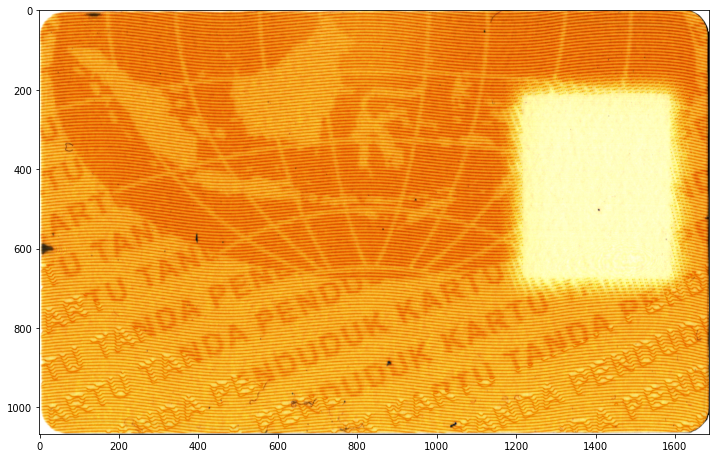

In [51]:
from skimage import data, exposure, filters
gamma_corrected = exposure.adjust_gamma(base_image, 6)
plt.imshow(gamma_corrected, cmap='gray')

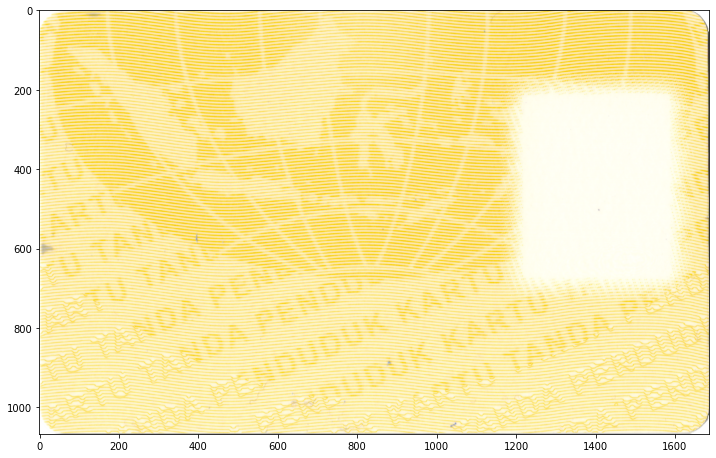

In [52]:
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)
adjusted = cv.convertScaleAbs(base_image, alpha=alpha, beta=beta)

plt.imshow(adjusted, cmap='gray')

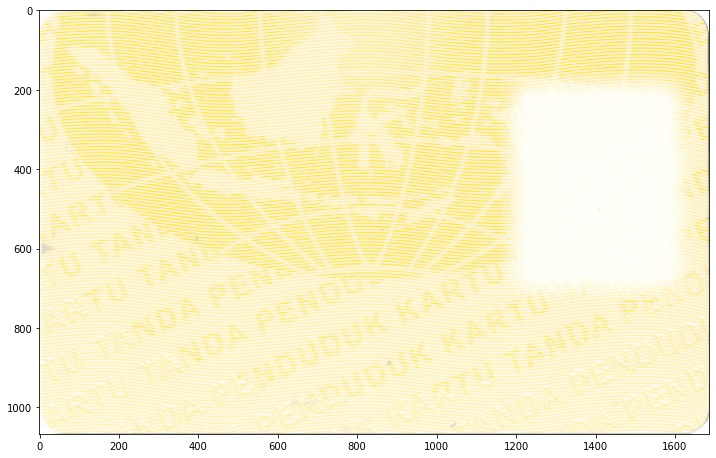

In [53]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv.LUT(image, table)

ajd_gam = adjust_gamma(base_image, gamma=2.0)
plt.imshow(ajd_gam)

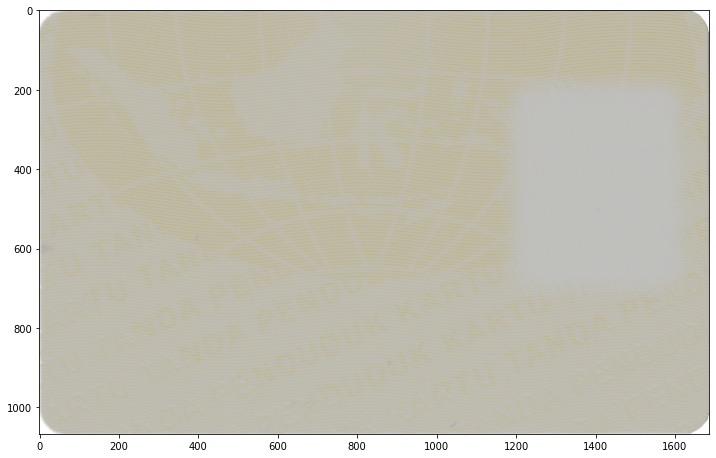

In [54]:
img_log = exposure.exposure.adjust_log(base_image, 0.5)
img_adapteq = exposure.equalize_adapthist(base_image, clip_limit=0.01)
plt.imshow(img_log, cmap='gray')

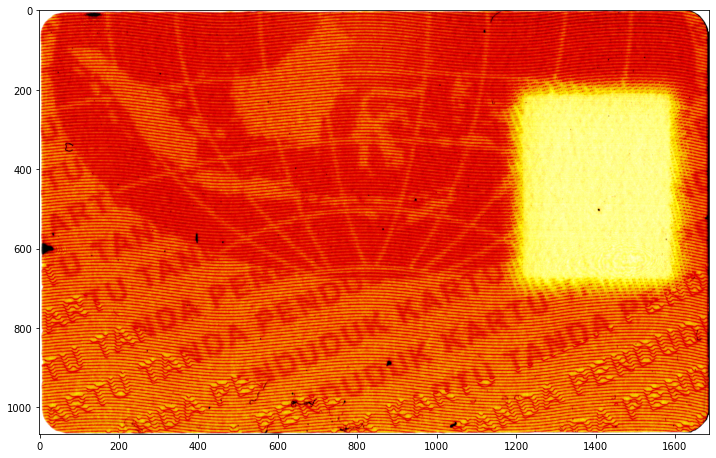

In [57]:
# Contrast stretching
p2, p98 = np.percentile(base_image, (30, 100))
img_rescale = exposure.rescale_intensity(base_image, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray')

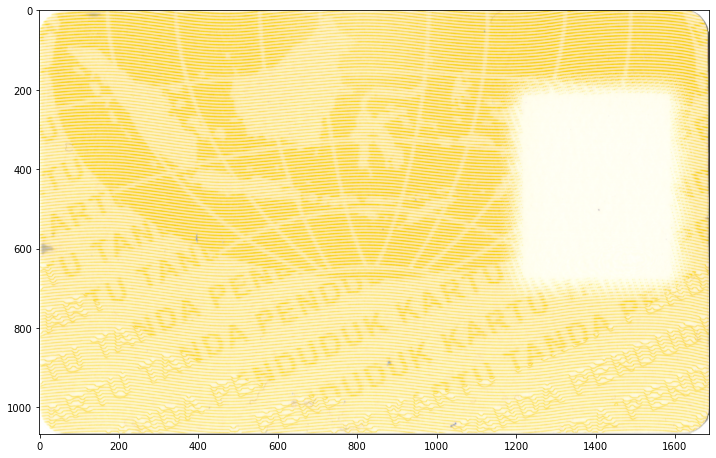

In [58]:
# Contrast stretching
img_gauss = filters.gaussian(base_image, sigma=0)
plt.imshow(img_gauss, cmap='gray')

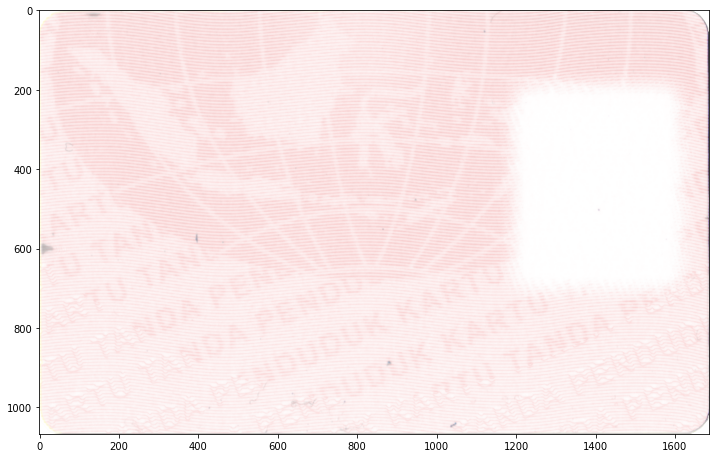

In [61]:
from skimage.morphology import disk
img_med = filters.median(base_image)
plt.imshow(img_med, cmap='gray')

In [78]:
def hue_shifting(image, shift):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    shift_h = (h + shift) % 180
    shift_hsv = cv.merge([shift_h, s, v])
    shift_img = cv.cvtColor(shift_hsv, cv.COLOR_HSV2BGR)
    return shift_img

shift_img = hue_shift(base_image, shift=30)

plt.imshow(cv.cvtColor(shift_img, cv.COLOR_BGR2RGB))

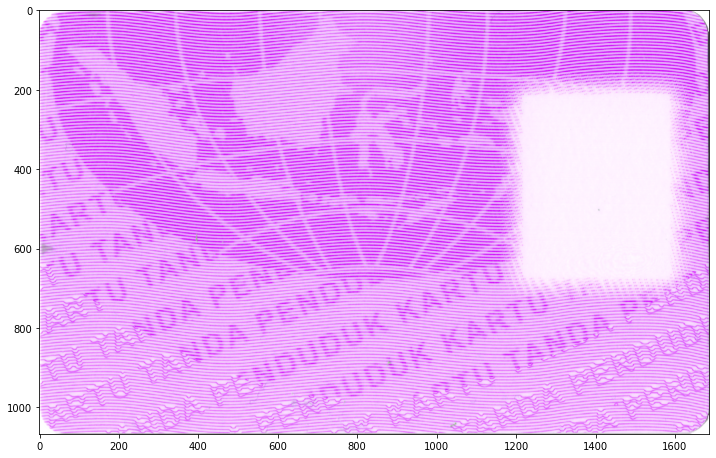

In [126]:
import random
def channel_shuffle(image):
    if len(image.shape)==3:
        b,g,r,a = cv.split(image)
        chan = [b,g,r]
        random.shuffle(chan)
        chan.append(a)
        rand_chan_image = cv.merge(chan)
    elif len(image.shape)==2:
        b,g,r = cv.split(image)
        chan = [b,g,r]
        random.shuffle(chan)
        rand_chan_image = cv.merge(chan)
    else:
        #reject later
        raise Exception("Image Channel must be more than BGR or BGRA, grayscale is not accepted")
    
    return rand_chan_image



img_shuff = channel_shuffle(base_image)
plt.imshow(img_shuff, cmap='gray')
# random.shuffle??

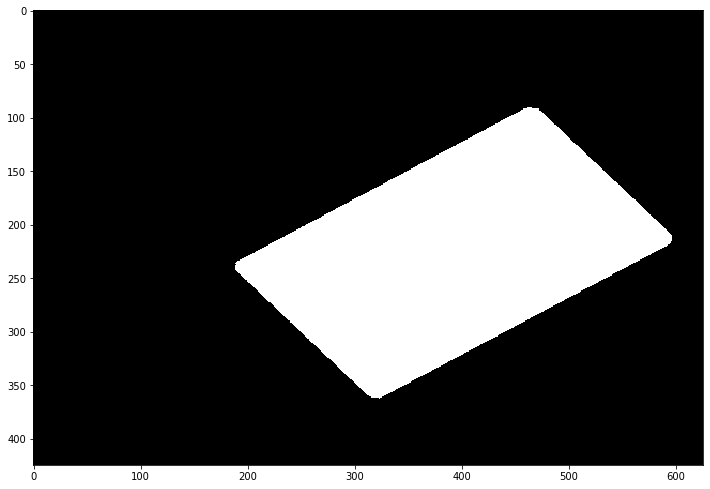

In [8]:
plt.imshow((seg_img*255).astype(np.uint8),cmap='gray')

[[185. 238.]
 [601. 214.]
 [601. 214.]
 [185. 238.]]


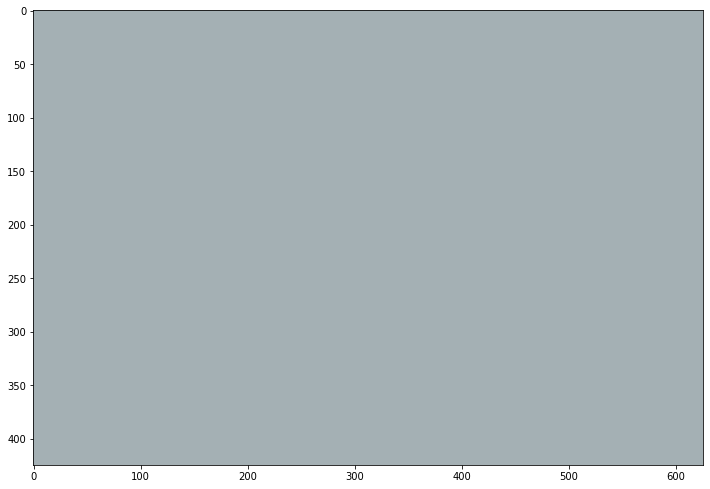

In [9]:
points = F.order_points(boxes[0])
print(points)
warped = F.four_point_transform(cmp_img.copy(), points)
plt.imshow(warped, cmap='gray');plt.show()

In [69]:
seg_img.dtype

dtype('float64')

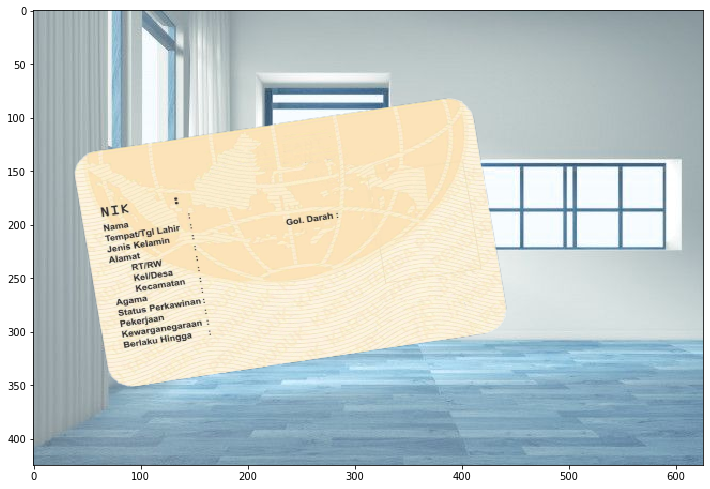

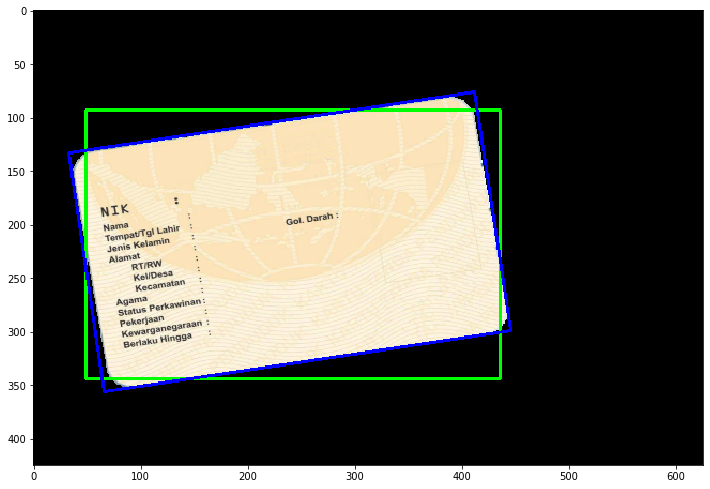

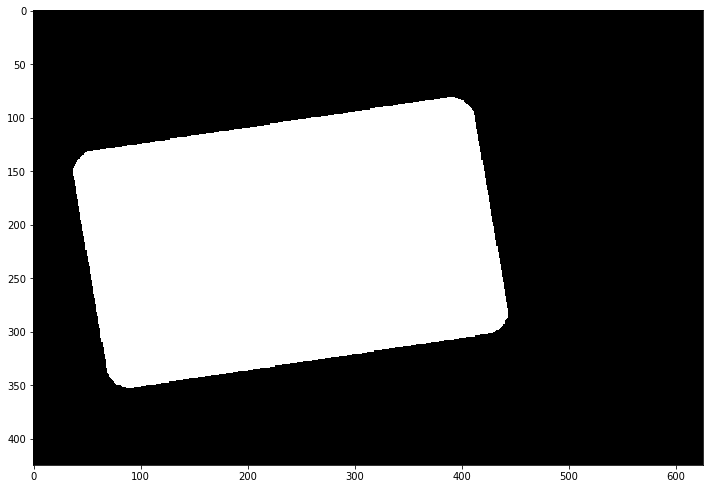

In [70]:
# base_segment = utils.image_selection(base_image, val=0)
# xmin,ymin,xmax,ymax = box  = F.to_xyminmax_box(boxes[0])
# rect = cv.boundingRect(boxes)
# x,y,w,h = rect
# print(box)
# croped = cmp_img[y:y+h, x:x+w].copy()

mask = seg_img.astype(np.uint8)
dst = cv.bitwise_and(cmp_img, cmp_img, mask=mask)
# print(dst.shape, dst.dtype)

edge = imutils.auto_canny(mask)
# points = cv.findNonZero(gray)

# contours,_ = cv.findContours(edge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
#
# for contour in contours:
#     (x,y,w,h) = cv.boundingRect(contour)
#     dst  = cv.rectangle(dst, (x,y), (x+w,y+h), (0,255,0), 4)
#
cnts = cv.findContours(edge.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv.minAreaRect, reverse = True)[:10]
#

# loop over our contours
screenCnt = None
for c in cnts:
    # approximate the contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * peri, True)
    # if len(approx) == 4:
    #     screenCnt = approx
    #     ((x,y),(w,h),angle) = cv.minAreaRect(c)
    #     rows,cols = mask.shape[:2]
    #     M = cv.getRotationMatrix2D((int(cols/2),int(rows/2)), angle, 1.0)
    #     nmask = cv.warpAffine(mask, M,(cols,rows))
    #     break
    if len(approx) == 4:
        # (x,y), (w,h), angle = cv.minAreaRect(c)
        # rows, cols = mask.shape[:2]
        # M = cv.getRotationMatrix2D((int(cols/2),int(rows/2)), angle, 1.0)
        # nmask = cv.warpAffine(mask, M,(cols,rows))
        screenCnt = approx
        x,y,w,h = cv.boundingRect(screenCnt)
        cv.rectangle(dst,(x,y),(x+w,y+h),(0,255,0),2)# <-- Get rectangle here
        # cv.rectangle(dst,(x,y),(x+w,y+h),(0,255,0),2)
        rect = cv.minAreaRect(c)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(dst,[box],0,(0,0,255),2)
        # break


# print(screenCnt)
# cv.drawContours(dst, [screenCnt], -1, (0, 255, 0), 3)


## (4) add the white background
# bg = np.ones_like(cmp_img, np.uint8)*255
# cv.bitwise_not(bg,bg, mask=mask)
# dst2 = bg+ dst

plt.imshow(cmp_img, cmap='gray');plt.show()
plt.imshow(dst, cmap='gray');plt.show()
plt.imshow(mask, cmap='gray'); plt.show()
# plt.imshow(nmask, cmap='gray'); plt.show()

# plt.imshow(dst2, cmap='gray');plt.show()

In [71]:
# base_img_size = base_image.shape[:2]
# back_img_size = back_image.shape[:2]
# bsn_h,bsn_w = bsn_size = utils.scale_size_ratio(back_img_size, base_img_size,  ratio=0.25)
# bsn_dsize = (bsn_w, bsn_h)
#
# box_xy = utils.random_safe_box_location(back_img_size, bsn_size)
# xmin, ymin, xmax, ymax = box_xy
#
# segment_image = utils.create_segmentation_image(base_segment, back_img_size, bsn_dsize, box_xy)
# overlay_image = utils.create_overlay_image(base_image, back_img_size, bsn_dsize, box_xy)
# result = utils.composite2image(back_image, overlay_image)
#
# plt.imshow(segment_image, cmap='gray');plt.show()
# plt.imshow(overlay_image, cmap='gray');plt.show()
# plt.imshow(result, cmap='gray');plt.show()
# print(box_xy)

In [72]:
# base_selection_resized = cv.resize(base_selection.copy(), dsize=bsn_dsize)
# base_image_segment = np.zeros(back_img_size)
# base_image_segment[ymin:ymax, xmin:xmax] = base_selection_resized
# segment_image = join2image(base_selection, back_img_size, bsn_size, box_xy)
#
#
# base_image_resized = cv.resize(base_image.copy(), dsize=bsn_dsize)
# base_image_overlay = np.zeros((back_img_size[0],back_img_size[1],4), np.uint8)
# base_image_overlay[ymin:ymax, xmin:xmax] = base_image_resized
#
# segment_image = join2image(base_selection, back_img_size, bsn_size, box_xy)
#
#
# result = utils.composite2image(back_image, base_image_overlay)


In [75]:
from pathlib import Path
list(Path('../data/background').glob("*.jpg"))

[]